# IMPORT LIBRARY

In [ ]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks


In [ ]:
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stop words) dalam berbagai bahasa.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# LOAD DATA

In [ ]:
df = pd.read_csv ("Scraping Review Mobile Legend App.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,38dd8857-1714-4522-ad32-c645569387a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saat Battlefield rank solo mengapa tim sendiri...,1,787,1.9.64.10601,2025-03-29 06:28:57,NaN,NaN,1.9.64.10601
1,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Game buruk, system matchmaking game paling bur...",4,185,1.9.64.10601,2025-03-28 09:50:38,NaN,NaN,1.9.64.10601
2,d7c2cb2d-48af-4959-999d-d7fff6d7182b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,asli nih game gak danta!! gua udah 7× main di ...,2,157,1.9.64.10601,2025-03-28 14:52:21,NaN,NaN,1.9.64.10601
3,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,1684,1.9.65.10602,2025-03-28 15:42:15,NaN,NaN,1.9.65.10602
4,ada60d3f-14b4-4a8d-a3d6-61ae50eebf55,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Pengalaman bermain yang buruk, Game sering fre...",1,1243,1.9.64.10601,2025-03-27 14:23:01,NaN,NaN,1.9.64.10601


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  19247 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          809 non-null    object
 9   repliedAt             809 non-null    object
 10  appVersion            19247 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


# DATA CLEANING

In [ ]:
# Mengisi NaN dengan versi aplikasi yang paling sering muncul (modus)
most_common_version = df['appVersion'].mode()[0]
most_common_review_version = df['reviewCreatedVersion'].mode()[0]

df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna(most_common_review_version)
df['appVersion'] = df['appVersion'].fillna(most_common_version)


In [ ]:
df['replyContent'] = df['replyContent'].fillna("No Reply")
df['repliedAt'] = df['repliedAt'].fillna("No Reply")


In [ ]:
print(df.isna().sum())

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
appVersion              0
dtype: int64


In [ ]:
print("Total duplikat:", df.duplicated().sum())

Total duplikat: 0


# Preprocessing

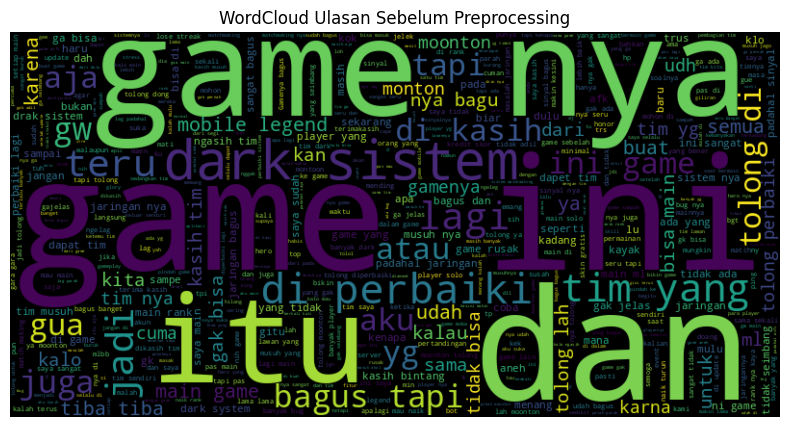

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Pastikan tidak ada nilai NaN pada kolom 'content'
df['content'] = df['content'].fillna('')

# Menggabungkan semua teks ulasan
text = ' '.join(df['content'].astype(str).tolist())

# Menentukan stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp'])

# Membuat objek WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=500, width=800, height=400)
wc.generate(text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Ulasan Sebelum Preprocessing")
plt.show()

## membersihkan dan memproses teks

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
def preprocess_text(text):
    """
    Membersihkan teks dengan menghapus URL, mengubah ke lowercase, menghapus mention dan hashtag,
    serta menghapus karakter spesial, tanda baca, dan angka.
    """
    # Hapus URL
    text = re.sub(r'https?\S+', ' ', text, flags=re.IGNORECASE)

    # Ubah ke huruf kecil
    text = text.lower()

    # Hapus mention dan hashtag
    text = re.sub(r'[@#]\S+', ' ', text)

    # Hapus karakter spesial dan tanda baca menggunakan modul string
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)

    # Hapus angka (jika diperlukan)
    text = re.sub(r'\d+', ' ', text)

    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [ ]:
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,38dd8857-1714-4522-ad32-c645569387a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saat Battlefield rank solo mengapa tim sendiri...,1,787,1.9.64.10601,2025-03-29 06:28:57,No Reply,No Reply,1.9.64.10601,saat Battlefield rank solo mengapa tim sendiri...,saat battlefield rank solo mengapa tim sendiri...,saat battlefield rank solo mengapa tim sendiri...,"[saat, battlefield, rank, solo, mengapa, tim, ...","[battlefield, rank, solo, tim, tim, musuh, sei...",battlefield rank solo tim tim musuh seimbang t...
1,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Game buruk, system matchmaking game paling bur...",4,185,1.9.64.10601,2025-03-28 09:50:38,No Reply,No Reply,1.9.64.10601,Game buruk system matchmaking game paling buru...,game buruk system matchmaking game paling buru...,game buruk system matchmaking game paling buru...,"[game, buruk, system, matchmaking, game, palin...","[game, buruk, system, matchmaking, game, buruk...",game buruk system matchmaking game buruk penye...
2,d7c2cb2d-48af-4959-999d-d7fff6d7182b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,asli nih game gak danta!! gua udah 7× main di ...,2,157,1.9.64.10601,2025-03-28 14:52:21,No Reply,No Reply,1.9.64.10601,asli nih game gak danta gua udah main di rank...,asli nih game gak danta gua udah main di rank...,asli ini game gak danta saya sudah main di ran...,"[asli, ini, game, gak, danta, saya, sudah, mai...","[asli, game, danta, main, rank, ngebug, bae, g...",asli game danta main rank ngebug bae gerak gil...
3,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,1684,1.9.65.10602,2025-03-28 15:42:15,No Reply,No Reply,1.9.65.10602,tiap main rank pasti aja ada player bebanmales...,tiap main rank pasti aja ada player bebanmales...,tiap main rank pasti saja ada player bebanmale...,"[tiap, main, rank, pasti, saja, ada, player, b...","[main, rank, player, bebanmales, main, player,...",main rank player bebanmales main player pengal...
4,ada60d3f-14b4-4a8d-a3d6-61ae50eebf55,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Pengalaman bermain yang buruk, Game sering fre...",1,1243,1.9.64.10601,2025-03-27 14:23:01,No Reply,No Reply,1.9.64.10601,Pengalaman bermain yang buruk Game sering free...,pengalaman bermain yang buruk game sering free...,pengalaman bermain yang buruk game sering free...,"[pengalaman, bermain, yang, buruk, game, serin...","[pengalaman, bermain, buruk, game, freezing, d...",pengalaman bermain buruk game freezing ditenga...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,f6e5fffb-d18f-4ee6-938c-1e0f147d3a04,Mahli Izuno,https://play-lh.googleusercontent.com/a-/ALV-U...,Game yg sangat seru dengan pemain yg sangat ra...,5,0,1.9.64.10601,2025-03-27 13:55:55,No Reply,No Reply,1.9.64.10601,Game yg sangat seru dengan pemain yg sangat ra...,game yg sangat seru dengan pemain yg sangat ra...,game yang sangat seru dengan pemain yang sanga...,"[game, yang, sangat, seru, dengan, pemain, yan...","[game, seru, pemain, ramah, tamah]",game seru pemain ramah tamah
19996,838a42db-21a4-4bb6-b0f2-359b1acdc4a9,Abdul Qodir,https://play-lh.googleusercontent.com/a/ACg8oc...,Matchmaking hancur jelek antara kedua tim tida...,2,0,1.8.34.9055,2024-05-19 14:59:06,No Reply,No Reply,1.8.34.9055,Matchmaking hancur jelek antara kedua tim tida...,matchmaking hancur jelek antara kedua tim tida...,matchmaking hancur jelek antara kedua tim tida...,"[matchmaking, hancur, jelek, antara, kedua, ti...","[matchmaking, hancur, jelek, tim, seimbang, ti...",matchmaking hancur jelek tim seimbang tim musu...
19997,b101bde0-1e19-4eeb-9a29-e7617716a2a0,Yosi Bleton,

## Mengambil lexicon Positif dan Negatif dari Github

In [ ]:
import csv
import requests
from io import StringIO

# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")


In [ ]:
def sentiment_analysis_lexicon_indonesia(token_list):
    """
    Menghitung skor sentimen berdasarkan lexicon.
    Parameter:
      token_list: List of tokens (kata-kata hasil tokenisasi)
    Mengembalikan:
      score (int): Skor sentimen kumulatif
      polarity (str): Label polaritas ('positive', 'neutral', 'negative')
    """
    score = 0

    # Menambahkan skor untuk kata-kata positif
    for word in token_list:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    # Menambahkan (atau mengurangi) skor untuk kata-kata negatif
    for word in token_list:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan label polaritas berdasarkan skor
    if score >= 0:
        polarity = 'positive'
    elif score <= -7:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [ ]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
negative    7563
positive    6777
neutral     5660
Name: count, dtype: int64


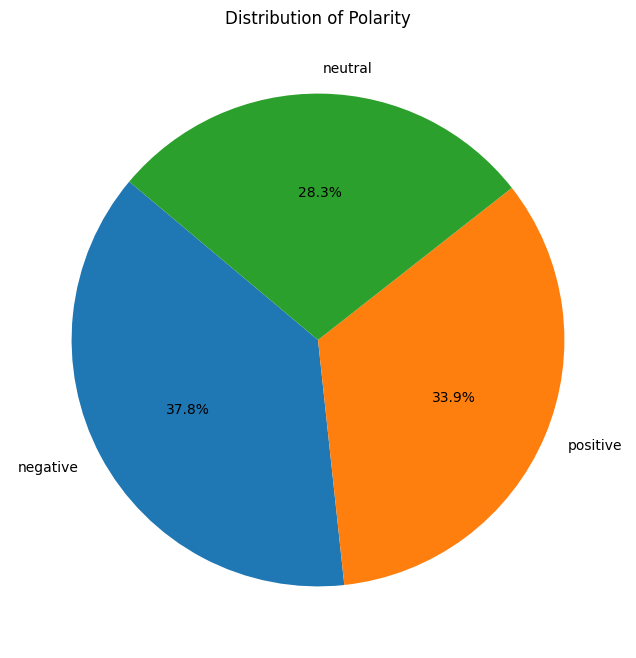

In [ ]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()

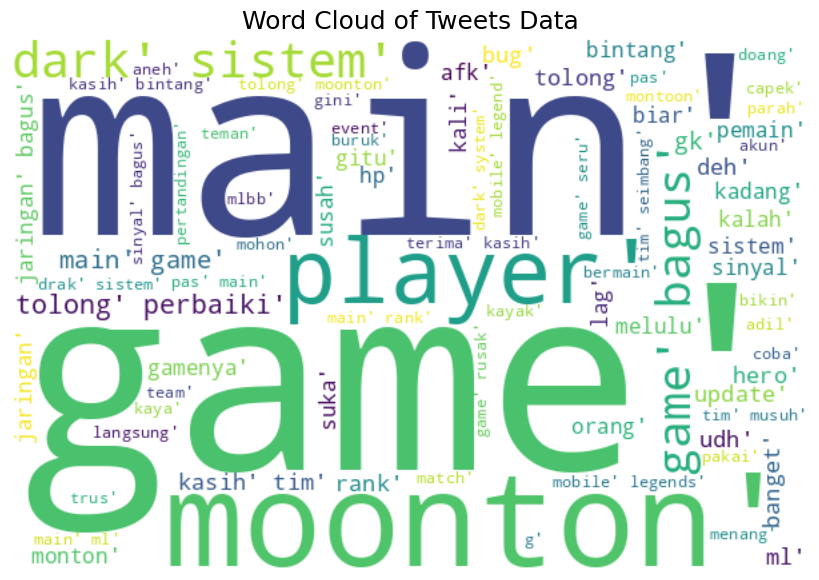

In [ ]:
all_text = ' '.join(df['text_stopword'].fillna('').astype(str))

# Membuat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_text)

# Menampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Membuat Data Frame Positive

In [ ]:
# Menampilkan kolom dengan lebar maksimum (opsional)
pd.set_option('display.max_colwidth', 3000)

# Buat DataFrame untuk tweet dengan label 'positive'
positive_tweets = df[df['polarity'] == 'positive']

# Pilih kolom yang relevan; sesuaikan dengan DataFrame Anda
# Di sini saya menggunakan 'text_akhir' (hasil gabungan token) dan 'text_stopword' sebagai teks yang telah diproses
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']] # Mengubah 'text_String' dan 'text_StopWord' menjadi 'text_akhir' dan 'text_stopword'

# Urutkan berdasarkan skor polaritas secara menurun (nilai tertinggi di atas)
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

# Untuk verifikasi, Anda dapat menampilkan beberapa baris dari positive_tweets
print(positive_tweets.head())

                                                                                                                                                                                                                                                                                                                               text_akhir  \
1  aspek teknis grafis kualitas visual detail animasi suara kualitas efek suara musik pengalaman audio performa kecepatan responsif stabilitas game aspek desain gameplay keseruan tantangan kepuasan bermain kontrol kemudahan responsifitas pengendalian karakter elemen game cerita kualitas narasi pengembangan karakter kejutan plot   
2                                                                                    bagus event skin gratis event top harga ramah skin diamond hero haya event beli game tergantung pengaturan grafis terkadang dark system bermain hindari afk hindari chat kasar game play fitur populer classic ranked selamat bermain mobile legends   
3

### Menampilkan Word Cloud untuk Label Positive

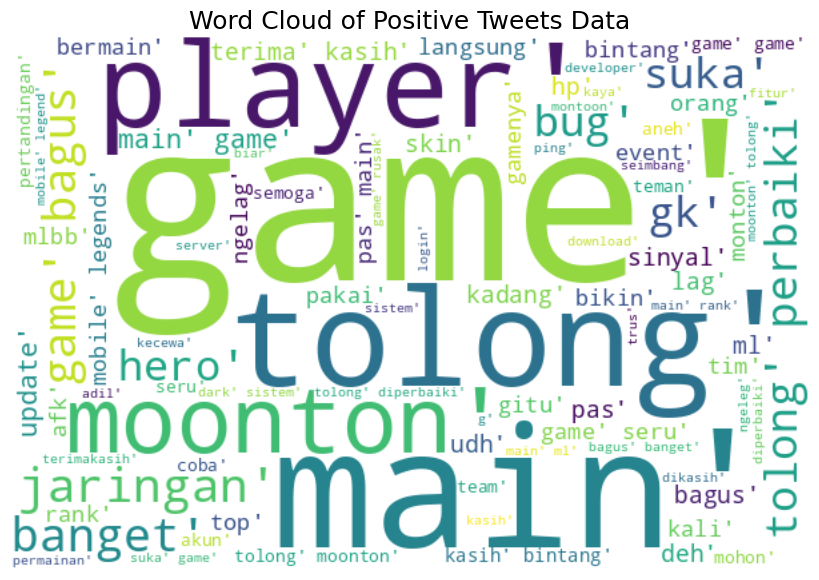

In [ ]:
# Menggabungkan seluruh teks dari kolom 'text_stopword' pada DataFrame positive_tweets
all_positive_text = ' '.join(positive_tweets['text_stopword'].fillna('').astype(str)) # Changed 'text_StopWord' to 'text_stopword'

# Membuat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_positive_text)

# Menampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Membuat DataFrame untuk Word Cloud Negative

In [ ]:
# Menampilkan kolom dengan lebar maksimum (opsional)
pd.set_option('display.max_colwidth', 3000)

# Ambil subset tweet dengan label 'negative'
negative_tweets = df[df['polarity'] == 'negative']

# 'text_akhir' dan 'text_stopword' karena nama kolom tersebut yang digunakan setelah preprocessing
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

# Urutkan berdasarkan skor polaritas secara menurun
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

# Tampilkan beberapa baris untuk verifikasi
print(negative_tweets.head())

                                                                                                                                                                                                                                             text_akhir  \
1                                                                                                                                                                                nerf hero layla kuat banget hero led gem sakit banget tnk nahan demeng   
2                                                                                                                                         aplikasi buruk main ngelekpadahal udh pakai wifi sm kuota tetep ngelek perbaikin bos server jualan skin doang   
3                                         maaf developer mobile legends kehilangan vibesselera bermain mobile legend teman² pensiun salah teman mabarsaudara dihack selera ditambah player² bermain alasan selera bermain maaf developer mobile legends

### Menampilkan Word Cloud untuk Label Negative

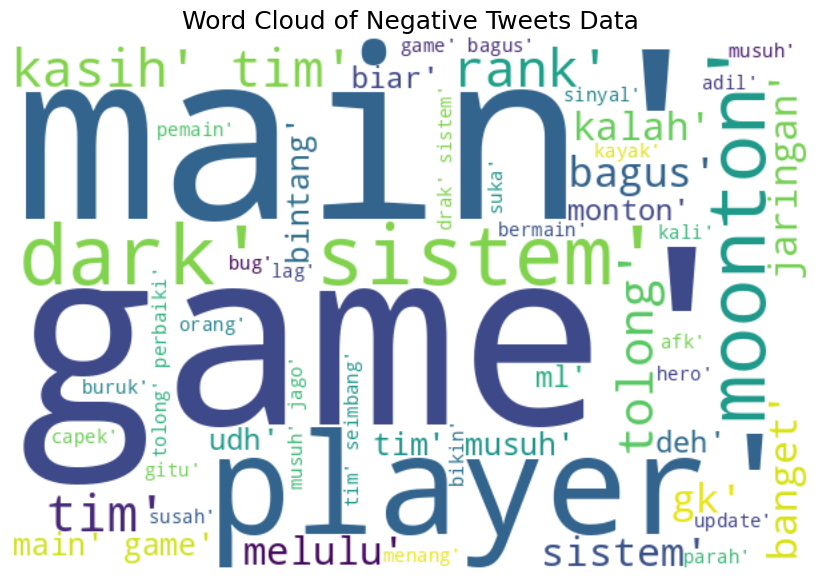

In [ ]:
# Gabungkan seluruh teks dari kolom 'text_StopWord' pada DataFrame negative_tweets
all_negative_text = ' '.join(negative_tweets['text_stopword'].fillna('').astype(str))

# Buat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_negative_text)

# Tampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Membuat DataFrame untuk Word Cloud Neutral

In [ ]:
# Menampilkan kolom dengan lebar maksimum (opsional)
pd.set_option('display.max_colwidth', 3000)

# Ambil subset tweet dengan label 'neutral'
neutral_tweets = df[df['polarity'] == 'neutral']

# Pilih kolom yang relevan, misalnya 'text_String' dan 'text_StopWord'
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

# Urutkan berdasarkan skor polaritas secara menurun
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

# Tampilkan beberapa baris untuk verifikasi
print(neutral_tweets.head())

                                                                                                                                                              text_akhir  \
1  game buruk system matchmaking game buruk penyeimbangan tim setara win x lose x stuck berputar perbaikan penyeimbangan matchmaking game game moba matchmaking terburuk   
2                                                  membedakan kemampuan player memberinya merata lawan hebat kemampuan player tim bermain berujung kalah tolong perbaiki   
3                                                                                                                               tolong perbaiki server nyasuka pas gawat   
4                                                                             moonton player aturan main solo ketemu player trol melulu game buruk perlakuan player solo   
5                                                bug game dark sistem game game kekurangannya hame memiliki keseimbangan terhadam tim tim se

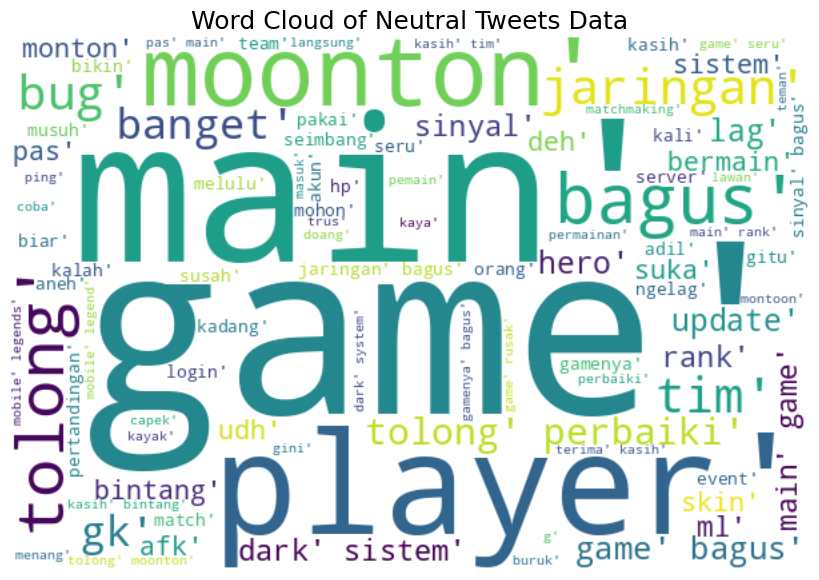

In [ ]:
# Menggabungkan seluruh teks dari kolom 'text_StopWord' pada DataFrame neutral_tweets
all_neutral_text = ' '.join(neutral_tweets['text_stopword'].fillna('').astype(str))

# Membuat word cloud dari teks yang telah digabungkan
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(all_neutral_text)

# Menampilkan word cloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Tweets Data', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Menampilkan Kata yang Paling Sering Muncul

<ipython-input-31-85e4227ce09a>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jumlah', y='index', data=tfidf_top20, palette='viridis')


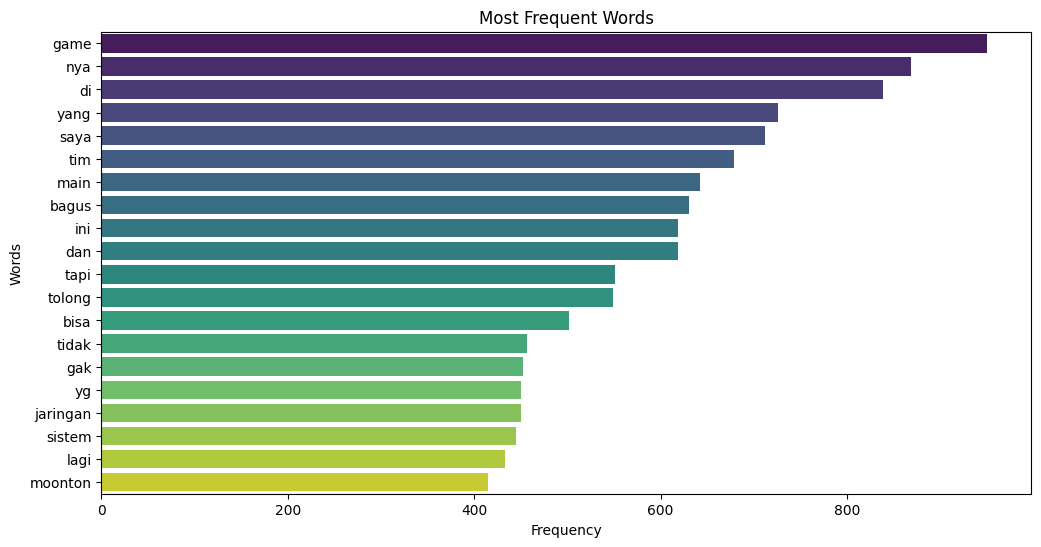

In [ ]:
# Pastikan kolom 'content' sudah bersih dari NaN dan berupa string
df['text_akhir'] = df['content'].fillna('').astype(str)

# Set ukuran figure
plt.figure(figsize=(12, 6))

# Menggunakan TfidfVectorizer untuk menghitung frekuensi kata pada kolom 'text_String'
from sklearn.feature_extraction.text import TfidfVectorizer # Import the TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])

# Membuat DataFrame TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Menjumlahkan setiap kata di seluruh dokumen
tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')

# Mengurutkan dan mengambil 20 kata dengan frekuensi tertinggi
tfidf_top20 = tfidf_sum.sort_values('jumlah', ascending=False).head(20)

# Menampilkan diagram batang
sns.barplot(x='jumlah', y='index', data=tfidf_top20, palette='viridis')
plt.title('Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

### Menampilkan Distribusi Panjang Teks

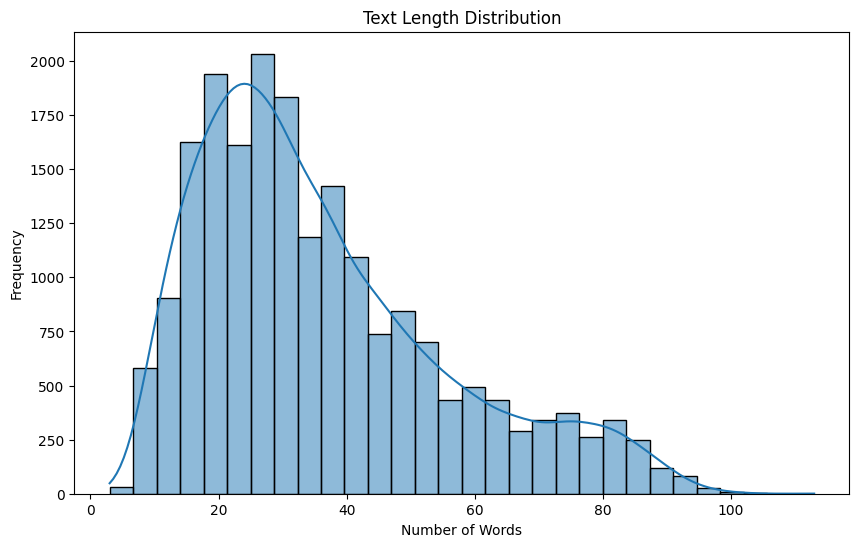

In [ ]:
# Pastikan kolom 'text_akhir' tidak memiliki nilai NaN dan berupa string
df['text_akhir'] = df['text_akhir'].fillna('').astype(str)

# Set ukuran figure
plt.figure(figsize=(10, 6))

# Menghitung panjang teks berdasarkan jumlah kata pada kolom 'text_String'
df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))

# Visualisasikan distribusi panjang teks
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

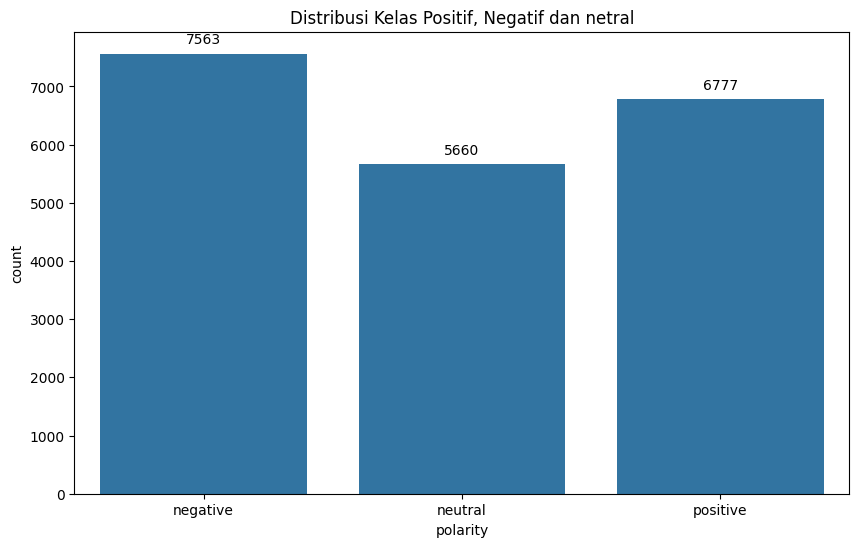

In [ ]:
# atur size
plt.figure(figsize=(10, 6))

# cek kelas distribusi
class_dist_plot = sns.countplot(x='polarity', data=df)
plt.title('Distribusi Kelas Positif, Negatif dan netral')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# MODELING

Saya Membuat Modeling yaitu dengan

1. Pelatihan: CNN,    Ekstraksi Fitur: Tokenizer,    Pembagian Data: 80/20
2. Pelatihan: GRU,    Ekstraksi Fitur: Tokenizer,    Pembagian Data: 70/30
3. Pelatihan: Transformer (BERT),    Ekstraksi Fitur: TF-IDF, Pembagian Data: 80/20   

## Data Split

In [ ]:
df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,38dd8857-1714-4522-ad32-c645569387a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"saat Battlefield rank solo mengapa tim sendiri antara tim musuh selalu tidak seimbang, misal tim saya kebanyakan pemula, sedangkan tim musuh kebanyakan Sepuh. Untuk itu awal nya masih bisa saya toleran namun kejadian ini sering sekali bahkan jika di hitung bisa 15 kali saya sudah tidak bisa menoleransi lagi hal tersebut, untuk kedepannya tolong lebih bijak saat Battlefield pemilihan tim sendiri dan tim musuh, sekali lagi mohon atas kebijakannya 🙏🙏",1,787,1.9.64.10601,2025-03-29 06:28:57,No Reply,No Reply,1.9.64.10601,saat Battlefield rank solo mengapa tim sendiri antara tim musuh selalu tidak seimbang misal tim saya kebanyakan pemula sedangkan tim musuh kebanyakan Sepuh Untuk itu awal nya masih bisa saya toleran namun kejadian ini sering sekali bahkan jika di hitung bisa kali saya sudah tidak bisa menoleransi lagi hal tersebut untuk kedepannya tolong lebih bijak saat Battlefield pemilihan tim sendiri dan tim musuh sekali lagi mohon atas kebijakannya,saat battlefield rank solo mengapa tim sendiri antara tim musuh selalu tidak seimbang misal tim saya kebanyakan pemula sedangkan tim musuh kebanyakan sepuh untuk itu awal nya masih bisa saya toleran namun kejadian ini sering sekali bahkan jika di hitung bisa kali saya sudah tidak bisa menoleransi lagi hal tersebut untuk kedepannya tolong lebih bijak saat battlefield pemilihan tim sendiri dan tim musuh sekali lagi mohon atas kebijakannya,saat battlefield rank solo mengapa tim sendiri antara tim musuh selalu tidak seimbang misal tim saya kebanyakan pemula sedangkan tim musuh kebanyakan sepuh untuk itu awal nya masih bisa saya toleran namun kejadian ini sering sekali bahkan jika di hitung bisa kali saya sudah tidak bisa menoleransi lagi hal tersebut untuk kedepannya tolong lebih bijak saat battlefield pemilihan tim sendiri dan tim musuh sekali lagi mohon atas kebijakannya,"[saat, battlefield, rank, solo, mengapa, tim, sendiri, antara, tim, musuh, selalu, tidak, seimbang, misal, tim, saya, kebanyakan, pemula, sedangkan, tim, musuh, kebanyakan, sepuh, untuk, itu, awal, nya, masih, bisa, saya, toleran, namun, kejadian, ini, sering, sekali, bahkan, jika, di, hitung, bisa, kali, saya, sudah, tidak, bisa, menoleransi, lagi, hal, tersebut, untuk, kedepannya, tolong, lebih, bijak, saat, battlefield, pemilihan, tim, sendiri, dan, tim, musuh, sekali, lagi, mohon, atas, kebijakannya]","[battlefield, rank, solo, tim, tim, musuh, seimbang, tim, kebanyakan, pemula, tim, musuh, kebanyakan, sepuh, toleran, kejadian, hitung, kali, menoleransi, kedepannya, tolong, bijak, battlefield, pemilihan, tim, tim, musuh, mohon, kebijakannya]","saat Battlefield rank solo mengapa tim sendiri antara tim musuh selalu tidak seimbang, misal tim saya kebanyakan pemula, sedangkan tim musuh kebanyakan Sepuh. Untuk itu awal nya masih bisa saya toleran namun kejadian ini sering sekali bahkan jika di hitung bisa 15 kali saya sudah tidak bisa menoleransi lagi hal tersebut, untuk kedepannya tolong lebih bijak saat Battlefield pemilihan tim sendiri dan tim musuh, sekali lagi mohon atas kebijakannya 🙏🙏",-33,negative,70
1,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Game buruk, system matchmaking game paling buruk yg pernah ada, penyeimbangan tim tidak setara. Setelah win 1x selanjutnya pasti lose 2x atau lebih, stuck dan terus berputar"" seperti itu. Jika tidak ada perbaikan mengenai penyeimbangan matchmaking, game ini akan menjadi game moba dengan matchmaking terburuk yang pernah ada.",

In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df['text_akhir']
y = df['polarity']

### Split data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding untuk target y
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

print("Shape of tokenized sequences:", X.shape)
print("Shape of target labels:", y.shape)
print("Number of classes:", num_classes)

Shape of tokenized sequences: (20000, 110)
Shape of target labels: (20000, 3)
Number of classes: 3


In [ ]:
import tensorflow as tf

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Pastikan nilai accuracy tersedia dan jika lebih dari 0.95, hentikan pelatihan
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.94:
            print(f"\nTraining accuracy telah melebihi 0.94, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True

early_stopping = CustomCallback()

## LSTM Model

### SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split
# Membagi dataset: 10% untuk uji, sisanya untuk train+validation
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

# Dari train+validation, ambil 20% sebagai validation (total: 70% training, 20% validation, 10% testing)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

print("Shape X_train_LSTM:", X_train_LSTM.shape)
print("Shape X_val_LSTM:", X_val_LSTM.shape)
print("Shape X_test_LSTM:", X_test_LSTM.shape)

Shape X_train_LSTM: (14000, 110)
Shape X_val_LSTM: (4000, 110)
Shape X_test_LSTM: (2000, 110)


### MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model_LSTM.summary()

# Melatih model dengan early stopping kustom (misalnya: berhenti jika akurasi training > 0.94)
batch_size = 2056
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=50,
    batch_size=batch_size,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=(X_val_LSTM, y_val_LSTM)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 - 113s - 16s/step - accuracy: 0.4156 - loss: 5.7736 - val_accuracy: 0.4588 - val_loss: 5.1539
Epoch 2/50
7/7 - 80s - 11s/step - accuracy: 0.4930 - loss: 4.7450 - val_accuracy: 0.5460 - val_loss: 4.1954
Epoch 3/50
7/7 - 91s - 13s/step - accuracy: 0.5735 - loss: 3.8552 - val_accuracy: 0.5897 - val_loss: 3.4405
Epoch 4/50
7/7 - 150s - 21s/step - accuracy: 0.6101 - loss: 3.1404 - val_accuracy: 0.6143 - val_loss: 2.8030
Epoch 5/50
7/7 - 124s - 18s/step - accuracy: 0.6453 - loss: 2.5564 - val_accuracy: 0.6047 - val_loss: 2.4252
Epoch 6/50
7/7 - 80s - 11s/step - accuracy: 0.6241 - loss: 2.2214 - val_accuracy: 0.6470 - val_loss: 1.9996
Epoch 7/50
7/7 - 78s - 11s/step - accuracy: 0.6645 - loss: 1.8479 - val_accuracy: 0.6675 - val_loss: 1.7208
Epoch 8/50
7/7 - 80s - 11s/step - accuracy: 0.6981 - loss: 1.5624 - val_accuracy: 0.6762 - val_loss: 1.4624
Epoch 9/50
7/7 - 83s - 12s/step - accuracy: 0.7126 - loss: 1.3255 - val_accuracy: 0.7030 - val_loss: 1.2644
Epoch 10/50
7/7 - 81s - 1

### Evaluasi

In [ ]:
# Evaluasi model pada data uji
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % score_LSTM)
print("Test accuracy: %.2f" % acc_LSTM)

63/63 - 5s - 82ms/step - accuracy: 0.7920 - loss: 0.6708
Test score: 0.67
Test accuracy: 0.79


## Model CNN

### SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split

# Memisahkan data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (16000, 110)
Shape X_test: (4000, 110)
Shape y_train: (16000, 3)
Shape y_test: (4000, 3)


### Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))  # Sesuaikan input length
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))

# Kompilasi model
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Tampilkan ringkasan model
model_CNN.summary()

# Melatih model dengan data latih (80%) dan menguji dengan data uji (20%)
batch_size = 2056
history_CNN = model_CNN.fit(
    X_train, y_train,  # Gunakan hanya data latih
    epochs=50,
    batch_size=batch_size,
    verbose=2,
    callbacks=[early_stopping]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 - 58s - 7s/step - accuracy: 0.4234 - loss: 1.0621
Epoch 2/50
8/8 - 79s - 10s/step - accuracy: 0.5384 - loss: 0.9451
Epoch 3/50
8/8 - 81s - 10s/step - accuracy: 0.6004 - loss: 0.8457
Epoch 4/50
8/8 - 84s - 11s/step - accuracy: 0.6666 - loss: 0.7438
Epoch 5/50
8/8 - 53s - 7s/step - accuracy: 0.7147 - loss: 0.6482
Epoch 6/50
8/8 - 82s - 10s/step - accuracy: 0.7539 - loss: 0.5679
Epoch 7/50
8/8 - 81s - 10s/step - accuracy: 0.7941 - loss: 0.4982
Epoch 8/50
8/8 - 53s - 7s/step - accuracy: 0.8189 - loss: 0.4456
Epoch 9/50
8/8 - 83s - 10s/step - accuracy: 0.8466 - loss: 0.3998
Epoch 10/50
8/8 - 80s - 10s/step - accuracy: 0.8648 - loss: 0.3724
Epoch 11/50
8/8 - 83s - 10s/step - accuracy: 0.8794 - loss: 0.3424
Epoch 12/50
8/8 - 82s - 10s/step - accuracy: 0.8869 - loss: 0.3225
Epoch 13/50
8/8 - 82s - 10s/step - accuracy: 0.8982 - loss: 0.3029
Epoch 14/50
8/8 - 82s - 10s/step - accuracy: 0.9088 - loss: 0.2864
Epoch 15/50
8/8 - 53s - 7s/step - accuracy: 0.9159 - loss: 0.2649
Epoch 16

### Evaluasi model CNN

In [ ]:
# Evaluasi akurasi pada training set
accuracy_train = history_CNN.history['accuracy'][-1]  # Mengambil akurasi dari epoch terakhir

# Evaluasi model pada testing set
loss_test, accuracy_test = model_CNN.evaluate(X_test, y_test, verbose=2)

# Menampilkan hasil akurasi
print(f"CNN - accuracy_train: {accuracy_train}")
print(f"CNN - accuracy_test: {accuracy_test}")

125/125 - 5s - 44ms/step - accuracy: 0.7975 - loss: 0.6544
CNN - accuracy_train: 0.9452499747276306
CNN - accuracy_test: 0.7975000143051147


In [ ]:
# Evaluasi model CNN pada data uji
score_CNN, acc_CNN = model_CNN.evaluate(X_test, y_test, verbose=2, batch_size=1028)
print("Test score: %.2f" % score_CNN)
print("Test accuracy: %.2f" % acc_CNN)

4/4 - 4s - 880ms/step - accuracy: 0.7975 - loss: 0.6544
Test score: 0.65
Test accuracy: 0.80


## MODEL GRU

### SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split

# Memisahkan data latih (70%) dan data uji (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (14000, 110)
Shape X_test: (6000, 110)
Shape y_train: (14000, 3)
Shape y_test: (6000, 3)


### MODEL GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_GRU.summary()

batch_size = 1028
history_GRU = model_GRU.fit(
    X_train, y_train,
    epochs=30,
    batch_size=batch_size,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
# Evaluasi pada training set
train_loss, train_accuracy = model_GRU.evaluate(X_train, y_train, verbose=2)
# Evaluasi pada testing set
test_loss, test_accuracy = model_GRU.evaluate(X_test, y_test, verbose=2)

print(f"GRU - accuracy_train: {train_accuracy:.4f}")
print(f"GRU - accuracy_test: {test_accuracy:.4f}")


In [ ]:
score_GRU, acc_GRU = model_GRU.evaluate(X_test, y_test, verbose=2)
print("Test score: %.2f" % score_GRU)
print("Test accuracy: %.2f" % acc_GRU)

## Hasil

In [ ]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Train': [
        history_LSTM.history['accuracy'][-1],
        history_CNN.history['accuracy'][-1],
        # history_GRU.history['accuracy'][-1]
    ],
    'Accuracy Test': [acc_LSTM, acc_CNN, acc_GRU]
})
print(results_df)

  Model  Accuracy Train  Accuracy Test
0  LSTM        0.896857         0.7920
1   CNN        0.945250         0.7975


In [ ]:
# Contoh data baru
new_texts = [
    "Aplikasi Game nya sangat bagus untuk saya",
    "Aplikasi ML ini sering Gangguan, kurang bagus",
    "saya suka, cuman setiap season harus ngulang"
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi dan padding untuk data baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Membuat prediksi menggunakan ketiga model
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Mengubah prediksi ke label (menggunakan argmax)
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

# Mengonversi label integer ke label asli menggunakan labelencoder
predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Menampilkan hasil prediksi
for text, true_label, label_LSTM, label_CNN, label_GRU in zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
Text: Aplikasi Game nya sangat bagus untuk saya
True Label: positive
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): positive

Text: Aplikasi ML ini sering Gangguan, kurang bagus
True Label: negative
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): positive

Text: saya suka, cuman setiap season harus ngulang
True Label: neutral
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): negative

